# Heart Disease: End-to-End Analysis & Classification

This notebook provides a complete workflow for a supervised classification project using the Cleveland Heart Disease dataset. You will:

1) **Load the dataset** from the UCI repository
2) **Clean and preprocess** the data 
3) Conduct **exploratory data analysis (EDA)** and interpret key tables & charts
4) Build a **baseline Logistic Regression** model
5) Train and tune a **Random Forest** model
6) Compute **feature importance** to understand signal
7) **Select high-importance features** and retrain models
8) Summarize findings and draft a brief **project report**


## Step 0: Setup & Imports

**What you'll do:** import core libraries and set global options for reproducible runs.

**Why it matters:** consistent environments and seeded randomness make your results comparable across runs and teams.


In [1]:

import os, urllib.request, warnings, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             RocCurveDisplay, roc_auc_score, precision_recall_curve, average_precision_score)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.feature_selection import SelectFromModel

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8,5)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Step 1: Download & Understand the Data
- Source: UCI ML Repository → `processed.cleveland.data`
- We'll assign the standard 14 feature names used in literature.
- Target `num` indicates disease presence 0 (no) to 4 (yes). We binarize as **presence vs absence**.

> If UCI endpoints ever change, update the `base_url` and try again.

**What you'll do:** fetch the raw data, apply official column names, and create the target variable.

**Why it matters:** clearly defined inputs and targets ensure downstream steps and metrics are valid.


In [2]:

DATA_DIR = "data_heart"
os.makedirs(DATA_DIR, exist_ok=True)
base_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/"
files = {
    "processed.cleveland.data": base_url + "processed.cleveland.data",
    "heart-disease.names": base_url + "heart-disease.names"
}
for fname, url in files.items():
    dest = os.path.join(DATA_DIR, fname)
    if not os.path.exists(dest):
        print(f"Downloading {fname} ...")
        urllib.request.urlretrieve(url, dest)
    else:
        print(f"Found {fname} (cached).")

# 14 commonly-used features + target 'num' (as per UCI notes / literature)
columns = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach",
           "exang","oldpeak","slope","ca","thal","num"]

df = pd.read_csv(os.path.join(DATA_DIR, "processed.cleveland.data"),
                 header=None, names=columns, na_values=["?"], skipinitialspace=True)

# Convert to numeric (some columns read as object due to NaNs)
for c in columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Binarize target: presence(1) if num>0 else 0
df["target"] = (df["num"] > 0).astype(int)
print("Shape:", df.shape)
df.head()


Found processed.cleveland.data (cached).
Found heart-disease.names (cached).
Shape: (303, 15)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


## Step 2: Data Cleaning
**Checklist**
- Handle missing values 
- Drop duplicate rows
- Quick sanity checks

**Why it matters**: Clean inputs prevent biased EDA and unstable models.

**What you'll do:** inspect and address duplicates, whitespace, and missing values.

**Why it matters:** cleaning reduces bias, prevents errors, and avoids misleading EDA or model behavior.


In [3]:

before = len(df); df.drop_duplicates(inplace=True); after = len(df)
print("Dropped duplicates:", before - after)
print("Missing values per column:")
display(df.isna().sum().sort_values(ascending=False))
display(df.describe().T)


Dropped duplicates: 0
Missing values per column:


ca          4
thal        2
age         0
trestbps    0
chol        0
sex         0
cp          0
restecg     0
fbs         0
thalach     0
exang       0
slope       0
oldpeak     0
num         0
target      0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0
sex,303.0,0.679868,0.467299,0.0,0.0,1.0,1.0,1.0
cp,303.0,3.158416,0.960126,1.0,3.0,3.0,4.0,4.0
trestbps,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.990099,0.994971,0.0,0.0,1.0,2.0,2.0
thalach,303.0,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


## Step 3: Preprocessing & Feature Engineering
- Here all features are numeric; if you add categoricals later, extend the transformer.

**What you'll do:** build preprocessing pipelines for numeric/categorical features (imputation, scaling, encoding).

In [4]:

X = df.drop(columns=["num","target"])
y = df["target"]

numeric_features = X.columns.tolist()
numeric_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])

preproc = ColumnTransformer([("num", numeric_pipe, numeric_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")


Train: (242, 13) | Test: (61, 13)


## Step 4: Exploratory Data Analysis (EDA) 
We will create visuals **and** generate a short **example analysis**

### 4.1 Class Balance

**What you'll do:** examine class balance, feature distributions, simple relationships to the target, and correlations.

**Why it matters:** EDA reveals signal vs. noise and informs modeling choices and feature engineering.


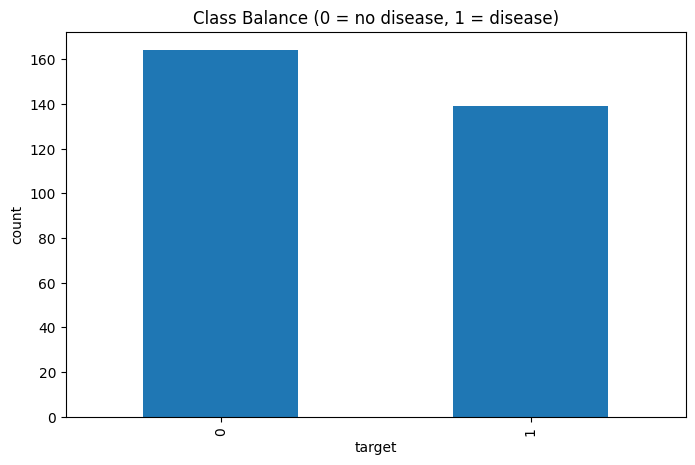

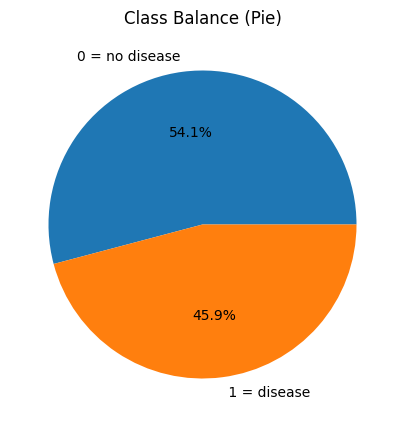

Example analysis: The dataset has 303 patients. About 45.9% show disease presence (target=1) and 54.1% show no disease (target=0). This indicates a fairly balanced target, which can affect evaluation metrics and threshold choices.


In [6]:

counts = y.value_counts().sort_index()
counts.plot(kind="bar")
plt.title("Class Balance (0 = no disease, 1 = disease)"); plt.xlabel("target"); plt.ylabel("count"); plt.show()

# Auto narrative
total = counts.sum()
pct1 = 100.0 * counts.loc[1] / total
pct0 = 100.0 * counts.loc[0] / total

plt.pie(counts.values, labels=["0 = no disease"," 1 = disease"], autopct="%1.1f%%"); plt.title("Class Balance (Pie)"); plt.show()
print(f"Example analysis: The dataset has {total} patients. About {pct1:.1f}% show disease presence (target=1) and {pct0:.1f}% show no disease (target=0). This indicates {'class imbalance' if pct1<40 or pct1>60 else 'a fairly balanced target'}, which can affect evaluation metrics and threshold choices.")


### 4.2 Distributions & Group Means (boxplots + summary table)
We compare key vitals by target and **print a human-readable summary**.

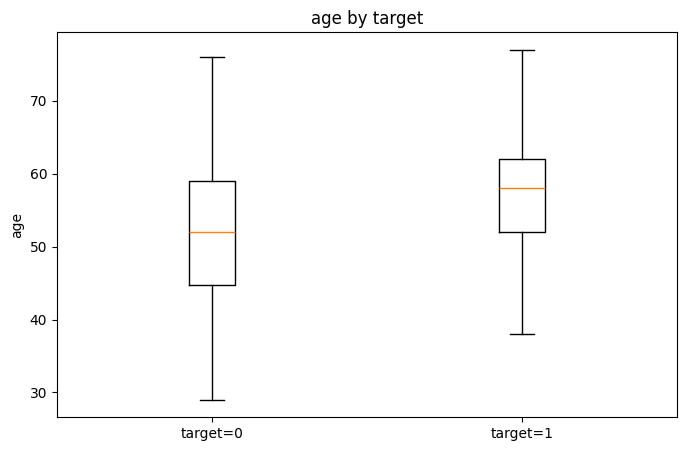

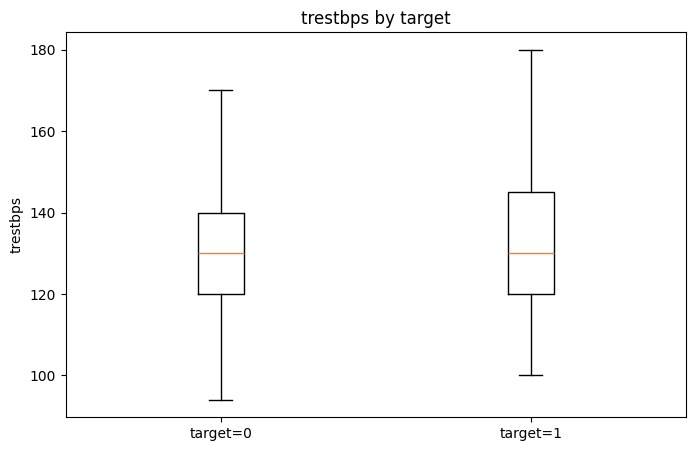

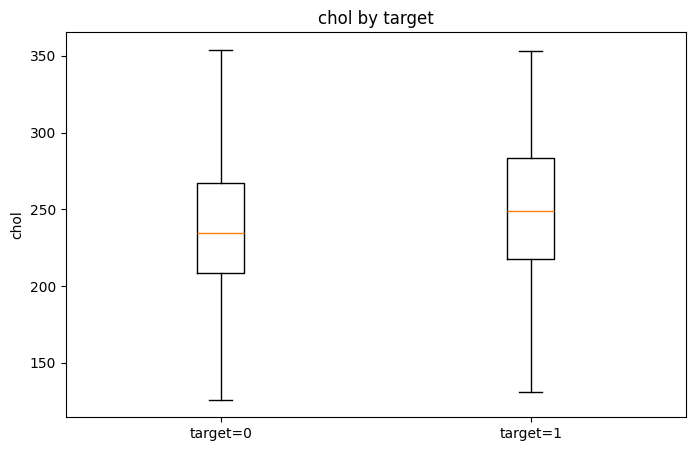

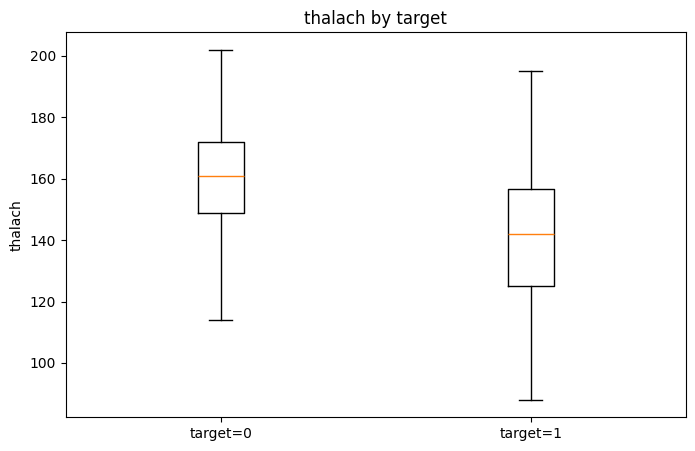

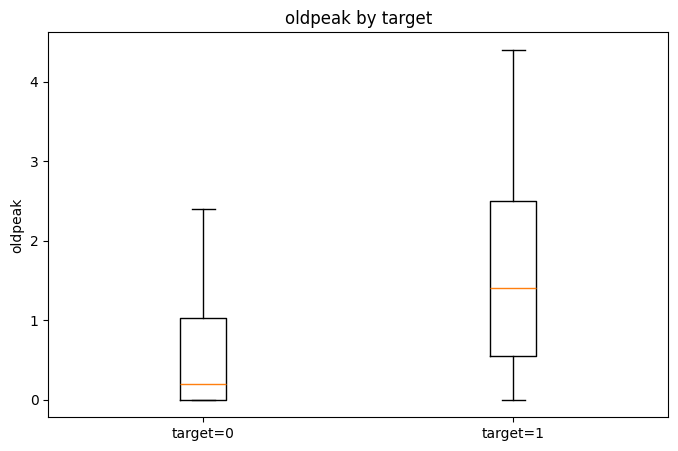

target,0,1
age,52.585366,56.625899
trestbps,129.250000,134.568345
chol,242.640244,251.474820
thalach,158.378049,139.258993
oldpeak,0.586585,1.574101


Example analysis:
When comparing group means, we see:
- **age**: avg is 56.6 for disease vs 52.6 for no disease → higher among positive class.
- **trestbps**: avg is 134.6 for disease vs 129.2 for no disease → higher among positive class.
- **chol**: avg is 251.5 for disease vs 242.6 for no disease → higher among positive class.
- **thalach**: avg is 139.3 for disease vs 158.4 for no disease → lower among positive class.
- **oldpeak**: avg is 1.6 for disease vs 0.6 for no disease → higher among positive class.
These patterns suggest which features might be predictive (e.g., lower thalach and higher oldpeak among disease cases). Avoid causal claims; these are associations.


In [7]:

key_numeric = ["age","trestbps","chol","thalach","oldpeak"]
# Boxplots
for col in key_numeric:
    d0 = df.loc[df["target"]==0, col].dropna()
    d1 = df.loc[df["target"]==1, col].dropna()
    plt.boxplot([d0, d1], labels=["target=0","target=1"], showfliers=False)
    plt.title(f"{col} by target"); plt.ylabel(col); plt.show()

# Group means summary + example narrative
means = df.groupby("target")[key_numeric].mean().T
display(means)

narrative_lines = []
for col in key_numeric:
    m0, m1 = means.loc[col, 0], means.loc[col, 1]
    trend = "higher" if m1>m0 else "lower"
    narrative_lines.append(f"- **{col}**: avg is {m1:.1f} for disease vs {m0:.1f} for no disease → {trend} among positive class.")
print("Example analysis:")
print("When comparing group means, we see:")
print("\n".join(narrative_lines))
print("These patterns suggest which features might be predictive (e.g., lower thalach and higher oldpeak among disease cases). Avoid causal claims; these are associations.")


### 4.3 Simple Risk Slices (thresholded views)
Show how risk (positive rate) changes across simple thresholds - for intuition.

In [8]:

def positive_rate(col, thresh, direction=">="):
    if direction == ">=":
        mask = df[col] >= thresh
    else:
        mask = df[col] < thresh
    rate = df.loc[mask, "target"].mean()
    return rate, mask.sum()

for col, (thresh, direction) in {"age":(55,">="),"chol":(240,">="),"thalach":(140,"<"),"oldpeak":(2.0,">=")}.items():
    rate, n = positive_rate(col, thresh, direction)
    print(f"{col} {direction} {thresh}: positive rate={rate:.2f} (n={n})")
print("Example analysis: Simple slices show how risk can vary across clinically sensible cut-offs, but proper modeling should consider all features jointly.")


age >= 55: positive rate=0.59 (n=160)
chol >= 240: positive rate=0.51 (n=156)
thalach < 140: positive rate=0.72 (n=85)
oldpeak >= 2.0: positive rate=0.85 (n=59)
Example analysis: Simple slices show how risk can vary across clinically sensible cut-offs, but proper modeling should consider all features jointly.


## Step 5: Baseline Model: Logistic Regression 
**What you'll do:** fit a Logistic Regression baseline and read the classification report, confusion matrix, ROC/PR curves.

**Why it matters:** baselines calibrate expectations and provide a reference for later models.


LogReg — Classification Report
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



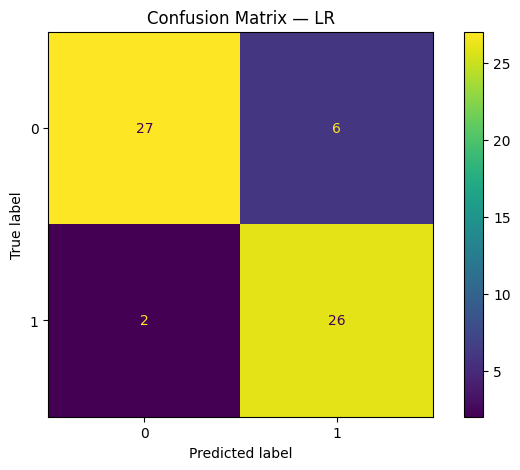

ROC AUC (LR): 0.951


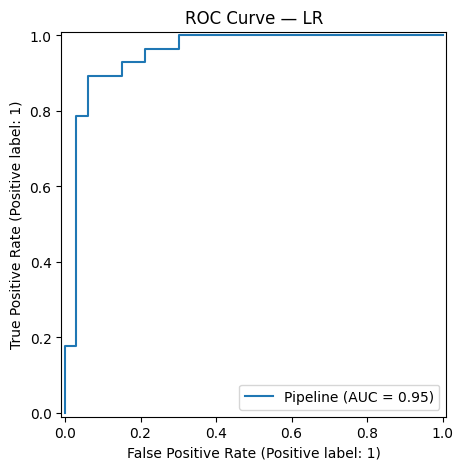

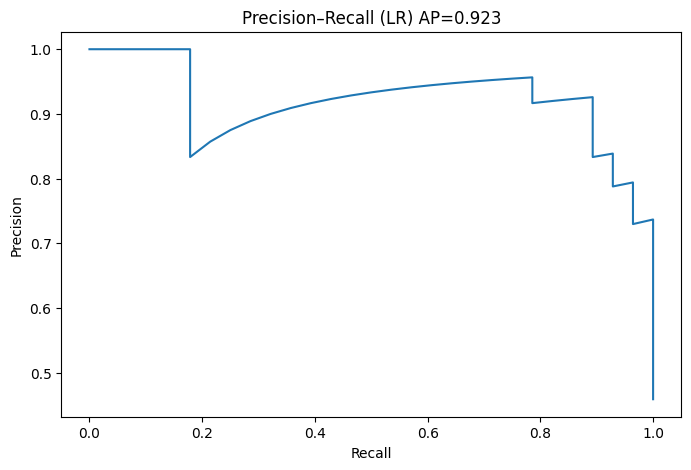

Example analysis: The PR curve summarizes performance on the positive class. If your project cares more about catching positives, focus on recall and choose a threshold that balances precision for your use case.


In [9]:

logreg = Pipeline([("prep", preproc), ("clf", LogisticRegression(max_iter=1000))])
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:,1]

print("LogReg — Classification Report")
print(classification_report(y_test, y_pred_lr))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr); plt.title("Confusion Matrix — LR"); plt.show()
auc_lr = roc_auc_score(y_test, y_proba_lr); print(f"ROC AUC (LR): {auc_lr:.3f}")
RocCurveDisplay.from_estimator(logreg, X_test, y_test); plt.title("ROC Curve — LR"); plt.show()

# Precision-Recall + narrative
from sklearn.metrics import precision_recall_curve, average_precision_score
p, r, t = precision_recall_curve(y_test, y_proba_lr)
ap = average_precision_score(y_test, y_proba_lr)
plt.plot(r, p); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall (LR) AP={ap:.3f}"); plt.show()
print("Example analysis: The PR curve summarizes performance on the positive class. If your project cares more about catching positives, focus on recall and choose a threshold that balances precision for your use case.")


## Step 6: Random Forest & Feature Importance 
We tune RF lightly, then compute **feature importances** on the test set and generate a readable summary.

**What you'll do:** train a tuned Random Forest and compute feature importance (including feature importance on a hold-out set).

**Why it matters:** tree ensembles often capture non-linear patterns; feature importance highlights which features drive performance.


Best RF params: {'clf__max_depth': None, 'clf__n_estimators': 300}
RF — Classification Report
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        33
           1       0.87      0.96      0.92        28

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61



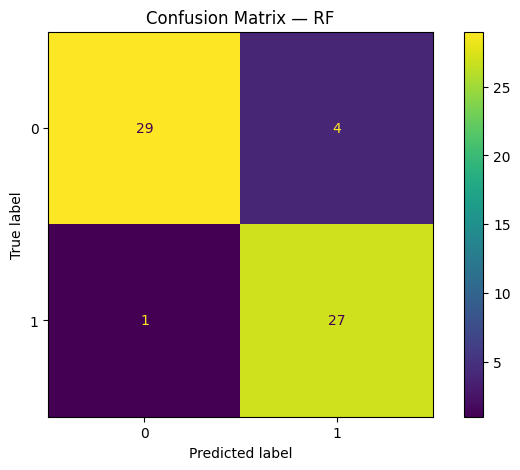

ROC AUC (RF): 0.958


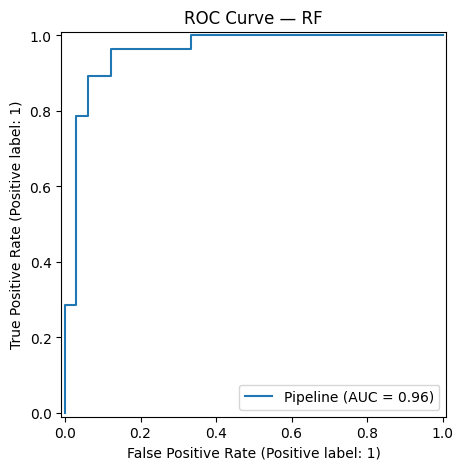

,feature,importance_mean,importance_std
11,ca,0.077049,0.022055
2,cp,0.068852,0.024093
7,thalach,0.044262,0.020801
12,thal,0.036066,0.017656
8,exang,0.032787,0.012698
0,age,0.026230,0.016718
9,oldpeak,0.024590,0.018328
3,trestbps,0.018033,0.011475
4,chol,0.018033,0.011475
10,slope,0.011475,0.016475


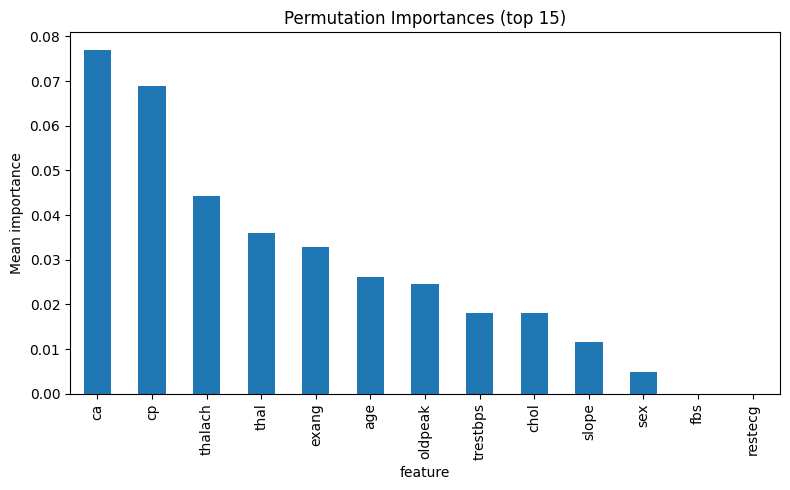

Example analysis: Based on permutation importance, top drivers in this split include:
- **ca**: importance=0.0770
- **cp**: importance=0.0689
- **thalach**: importance=0.0443
- **thal**: importance=0.0361
- **exang**: importance=0.0328
Interpretation: These features had the largest drop in model score when shuffled, suggesting strong predictive signal. Do NOT treat this as causality.


In [10]:

rf = Pipeline([("prep", preproc), ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])
grid = GridSearchCV(rf, param_grid={"clf__n_estimators":[300,600], "clf__max_depth":[None,6,12]},
                    scoring="f1", cv=3, n_jobs=-1, verbose=0)
grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
print("Best RF params:", grid.best_params_)

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]
print("RF — Classification Report")
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf); plt.title("Confusion Matrix — RF"); plt.show()
auc_rf = roc_auc_score(y_test, y_proba_rf); print(f"ROC AUC (RF): {auc_rf:.3f}")
RocCurveDisplay.from_estimator(best_rf, X_test, y_test); plt.title("ROC Curve — RF"); plt.show()

# Permutation importance
perm = permutation_importance(best_rf, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
feat_names = numeric_features  # all numeric
import pandas as pd
perm_df = pd.DataFrame({"feature": feat_names,
                        "importance_mean": perm.importances_mean,
                        "importance_std": perm.importances_std}).sort_values("importance_mean", ascending=False)
display(perm_df)
perm_df.head(15).set_index("feature")["importance_mean"].plot(kind="bar")
plt.title("Permutation Importances (top 15)"); plt.ylabel("Mean importance"); plt.tight_layout(); plt.show()

# Narrative: top 5
top5 = perm_df.head(5)
bullets = [f"- **{row.feature}**: importance={row.importance_mean:.4f}" for row in top5.itertuples(index=False)]
print("Example analysis: Based on permutation importance, top drivers in this split include:")
print("\n".join(bullets))
print("Interpretation: These features had the largest drop in model score when shuffled, suggesting strong predictive signal. Do NOT treat this as causality.")


## Step 7: Feature Selection & Retraining Train with High-Importance Features Only
We select features using `SelectFromModel(RandomForest)` (threshold=mean) and retrain both LR and RF. Then compare metrics.

**What you'll do:** select high-importance features with `SelectFromModel`, retrain models, and compare metrics (AUC, F1).

**Why it matters:** smaller, focused feature sets can simplify models, improve generalization, and ease explanation.


In [11]:

from collections import OrderedDict
sel_lr = Pipeline([("prep", preproc),
                   ("select", SelectFromModel(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))),
                   ("clf", LogisticRegression(max_iter=1000))])
sel_rf = Pipeline([("prep", preproc),
                   ("select", SelectFromModel(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))),
                   ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])
sel_lr.fit(X_train, y_train)
sel_rf.fit(X_train, y_train)

def eval_model(name, model):
    yp = model.predict(X_test); ypp = model.predict_proba(X_test)[:,1]
    report = classification_report(y_test, yp, output_dict=True)
    return OrderedDict(Model=name, AUC=roc_auc_score(y_test, ypp),
                       F1_weighted=report["weighted avg"]["f1-score"])

results = []
results.append(eval_model("LR (All features)", logreg))
results.append(eval_model("RF (All features)", best_rf))
results.append(eval_model("LR (Selected features)", sel_lr))
results.append(eval_model("RF (Selected features)", sel_rf))
res_df = pd.DataFrame(results); display(res_df)
print("Example analysis: Compare rows to see if feature selection simplified models without hurting performance. If scores are similar (or better) after selection, you gained a **leaner** model that may generalize better and be easier to explain.")


,Model,AUC,F1_weighted
0,LR (All features),0.951299,0.868993
1,RF (All features),0.957792,0.918165
2,LR (Selected features),0.944805,0.868993
3,RF (Selected features),0.930736,0.885370


Example analysis: Compare rows to see if feature selection simplified models without hurting performance. If scores are similar (or better) after selection, you gained a **leaner** model that may generalize better and be easier to explain.


## Step 8: Summary & Next Steps Summary & Writing Template
**What we did**: Data download, cleaning, pipelines, EDA with guided narratives, baseline LR, tuned RF, feature importance, and feature selection + comparison.
- **Data & Target**: Describe size, variables, and target definition (binarized from `num`).
- **Class Balance**: State percentages and whether imbalance is present; discuss impact on metrics.
- **Key Patterns**: Use group means/boxplots to summarize which features differ between classes (no causality claims).
- **Modeling**: Report LR & RF scores (AUC/F1) and confusion matrices; link performance to project goals.
- **Feature Importance**: List top 5 important features (permutation) and what they mean for predictions.
- **Selection Effect**: Compare full vs selected-feature models; discuss trade-offs.


**What you'll do:** summarize key findings, document limitations, and propose next steps.

**Why it matters:** clear communication turns technical work into actionable insight.
